# Algorithms for Data Science

## Filtering Stream Items

### 1. Preliminaries 

The objective of this lab is to implement algorithms for filtering "good" items on streams. We will start by the simple implementation using only one hash function, and then it will be required of you to implement the full Bloom filter. We assume a random stream $S$ of $m$ email strings. We assume that the first $g$ emails are the good ones, that we have $n$ bits allocated in the bit array $B$ (for simplicity, implemented as an array here).

In [93]:
import random
from string import ascii_lowercase

#parameters
m = 100
g = 10 # number of good ones
stream_size = 10000
n = 512 # bits

#generate some random strings of size 5 + 1 + 5
D = []
for _ in range(m):
  D.append(''.join(random.choice(ascii_lowercase) for i in range(5))+\
           '@'+''.join(random.choice(ascii_lowercase) for i in range(5)))

print(D)

['ltnft@vjnif', 'phehu@fxcfc', 'jfgtv@zczou', 'yncuj@kwiep', 'ndefy@smmhh', 'kskcu@jjovf', 'azgsh@gvwux', 'mycdf@oioal', 'emovw@wlsoa', 'hcvzm@zhlab', 'mudmb@uefmu', 'efhca@ouaks', 'eetdb@vnupu', 'jsjrm@gfuik', 'idzfs@zgfqy', 'oqccc@esdzt', 'scfpx@xthnh', 'gjgeh@xdmal', 'qcgni@gvuof', 'ygbxe@txsyh', 'qtpej@tmngo', 'dwncj@addua', 'lgmdf@ikayz', 'ndvnq@jbezi', 'ohusw@vugsv', 'ktnvb@uazeb', 'fsaob@ltgge', 'tllna@vbzkd', 'tmyrp@dpopb', 'knjnk@cvjkh', 'igtth@sgpbr', 'sslvw@cmysl', 'fkekd@rbkyv', 'zicne@oidfs', 'wbzrh@lnkzs', 'abqcf@focyg', 'ytjyj@rfvxp', 'gcexs@ybvji', 'znfil@gihmv', 'pgjkw@tqpwj', 'hkhpy@coapm', 'dnmbf@kxtwr', 'bmwhw@jpbos', 'uldqc@lrcvz', 'fefci@fzfzj', 'qteve@nymzs', 'vzmbz@glqqv', 'guqed@adwhg', 'tdjuj@oiora', 'brymd@wmznz', 'ervpb@amish', 'usdta@xoaus', 'bkedx@cmibp', 'pyvhz@opeqa', 'adurt@swgms', 'qucrq@ppbnp', 'nxctc@ocwfv', 'tngwg@lplhf', 'idevx@qffyw', 'icacs@kthir', 'osxzu@orwtd', 'wvjml@hvmfc', 'mpsqs@mrdee', 'gifjn@ejzyf', 'mmhgr@fvtfg', 'pwioe@zaamq', 'sqihx@sb

### 2. Creating a Hash Function, Filtering Items Using a Single Hash

In the following we create a hash function $h(x)$, which also takes as a parameter a value and $n$, and returns a value in $0\dots n-1$. We populate the byte array $B$, and then we simulate a stream taking random values from $D$ and checking whether the value is good or not. We measure the true positive, false positive, and false negative rates. 

In [25]:

def h(x,n):
  return hash(x)%n
n=h('ptyzv@zyixz',128)
B[n]

1

In [55]:
n = 128

#hash function
def h(x,n):
  return hash(x)%n  # keep the last bits from the hash

good_set = set(D[:g]) #just for checking TP and FP rates

#allocate the array of 0s
B = [0] * n

#fill the byte array
for i in range(g): B[h(D[i],n)] = 1  
    
print(B)

tp = 0 # good items passing
fp = 0 # bad items passing
tn = 0 # bad items discarded
fn = 0 # good items discarded

#simulate a stream
for _ in range(stream_size):
  #take a random email
  s = random.choice(D)
  #check its hash value
  if B[h(s,n)]==1: #good
    if s not in good_set:
      fp += 1
    else:
      tp += 1
  else: #bad 
    if s in good_set:
      fn += 1
    else:
      tn += 1

print('False positive rate: %f'%(float(fp)/float(tn+fp)))

[1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
False positive rate: 0.044188


We may want to create a random hash function that can also be pairwise independent when we will need to generate $k$ independent pairwise hashes.
The following procedure can be implemented:
* choose a large prime number $p$
* generate two random numbers $a$ and $b$ in the range $\{1,\dots,p\}$
* the hash is then $h_{a,b}(x)=ax+b \mod p$
* we can also restrict it into $\{0,\dots,n-1\}$

In [28]:
p = 1223543677

a = random.randrange(p)
b = random.randrange(p)

def h(x,a,b,p,n):
  return ((a*hash(x)+b)%p)%n
#remark: here we use hash(x) instead of the values to allow for all hashable python types
#   e.g., strings, tuples

#reinitialize the array, for testing
B = [0] * n

for i in range(g): 
  B[h(D[i],a,b,p,n)] = 1

print(B)



[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


### 3. **TASK** - Bloom Filters

Your task is to implement the Bloom filters as described in the class lecture. For this, you have to:
1. generate $k$ random pairwise independent hash functions (_hint_: use the example shown above)
2. initialize $B$, by setting $1$ in each $h_i(x)$, $i\in\{1,\dots,k\}$, for all items $x$ in the good set
3. an item $s$ in the stream is considered good if, for all $i\in\{1,\dots,k\}$, we have $B[h_i(s)]=1$

Measure the true positive and false positive rate for various values of $k$ and compare to the values obtained when setting $k=n/m\ln 2$ (to the nearest integer value). What do you notice?

Rates:

$
  \text{false positive rate} \frac{FP}{FP+TN}
$

$
  \text{true positive rate} \frac{TP}{TP+FN}
$

**Try to validate the number of hash functions with fp and tp** (varying hush functions k and calculate the FP)

Change m, g to see how it works

In [100]:
p = 1223543677
a = random.randrange(p)
b = random.randrange(p)
a

587204757

In [70]:
# YOUR CODE HERE
k = 1 # number of hush functions
#reinitialize the array, for testing
B = [0] * n

a_list=[]
b_list=[]

def h(x,a,b,p,n):
  return ((a*hash(x)+b)%p)%n

for i in range(k):

    p = 1223543677
    a = random.randrange(p)
    a_list.append(a)
    b = random.randrange(p)
    b_list.append(b)
    
    for i in range(g):
        B[h(D[i],a,b,p,n)] = 1

print(B)

#simulate a stream
for _ in range(stream_size):
  #take a random email
  s = random.choice(D)
  #check its hash value
  for i in range(k):

    a = a_list[i]
    b = b_list[i]
    num=0 
    if B[h(s,a,b,p,n)] == 1:
        num +=1
    if num == k: # good
        if s not in good_set:
          fp += 1
        else:
            tp+=1
    else: #bad
        if s in good_set:
          fn += 1
        else:
          tn += 1

print('False positive rate: %f'%(float(fp)/float(tn+fp)))
#remark: here we use hash(x) instead of the values to allow for all hashable python types
#   e.g., strings, tuples

[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0]
False positive rate: 0.063195


In [91]:
import numpy as np
k_list=list(range(1,21))
fp_list=[]
n=128
def h(x,a,b,p,n):
  return ((a*hash(x)+b)%p)%n

for k in k_list:
    fp=0
    tp=0
    fn=0
    tn=0
    B = [0] * n
    a_list=[]
    b_list=[]
    for i in range(k):

        p = 1223543677
        a = random.randrange(p)
        a_list.append(a)
        b = random.randrange(p)
        b_list.append(b)

        for i in range(g):
            B[h(D[i],a,b,p,n)] = 1

    for _ in range(stream_size):
        #take a random email
        s = random.choice(D)
        #check its hash value
        for i in range(k):

            a = a_list[i]
            b = b_list[i]
            num=0 
            if B[h(s,a,b,p,n)] == 1:
                num +=1
        if num == k: # good
            if s not in good_set:
                fp += 1
            else:
                tp+=1
        else: #bad
            if s in good_set:
                fn += 1
            else:
                tn += 1
    fp_rate=float(fp)/float(tn+fp)
    print('False positive rate: %f'%(float(fp)/float(tn+fp)))

False positive rate: 0.054566
False positive rate: 0.000000
False positive rate: 0.000000
False positive rate: 0.000000
False positive rate: 0.000000
False positive rate: 0.000000
False positive rate: 0.000000
False positive rate: 0.000000
False positive rate: 0.000000
False positive rate: 0.000000
False positive rate: 0.000000
False positive rate: 0.000000
False positive rate: 0.000000
False positive rate: 0.000000
False positive rate: 0.000000
False positive rate: 0.000000
False positive rate: 0.000000
False positive rate: 0.000000
False positive rate: 0.000000
False positive rate: 0.000000


_You can use this cell to write your discussion of the results_

In [111]:
import numpy as np
k_list=list(range(1,51))
fp_list=[]
n=128
def h(x,a,b,p,n):
  return ((a*hash(x)+b)%p)%n

for k in k_list:
    fp=0
    tp=0
    fn=0
    tn=0
    B = [0] * n
    a_list=[]
    b_list=[]
    p = 1223543677
    for i in range(k):

        a = random.randrange(p)
        a_list.append(a)
        b = random.randrange(p)
        b_list.append(b)

        for i in range(g):
            B[h(D[i],a,b,p,n)] = 1

    for _ in range(stream_size):
        #take a random email
        s = random.choice(D)
        #check its hash value
        
        if min([ B[h(s,a,b,p,n)] for a,b in zip(a_list,b_list)])==1:

            if s not in good_set:
                fp += 1
            else:
                tp+=1
        else: #bad
            if s in good_set:
                fn += 1
            else:
                tn += 1
    fp_rate=float(fp)/float(tn+fp)
    fp_list.append(fp_rate)
    #print('False positive rate: %f'%(float(fp)/float(tn+fp)))

In [112]:
print(fp_list)

[0.1768, 0.1319, 0.1014, 0.1047, 0.0966, 0.0985, 0.1076, 0.0993, 0.1011, 0.1142, 0.0977, 0.0999, 0.095, 0.0963, 0.1085, 0.1132, 0.1012, 0.0947, 0.1214, 0.1035, 0.1405, 0.1111, 0.1048, 0.1061, 0.1243, 0.1754, 0.1001, 0.1179, 0.1236, 0.1403, 0.1295, 0.1413, 0.1668, 0.1477, 0.1296, 0.3507, 0.2266, 0.3683, 0.3045, 0.2774, 0.3601, 0.1402, 0.353, 0.306, 0.421, 0.6143, 0.5349, 0.7135, 0.3037, 1.0]


In [113]:
print(k_list)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50]


## Print the k-fp curve

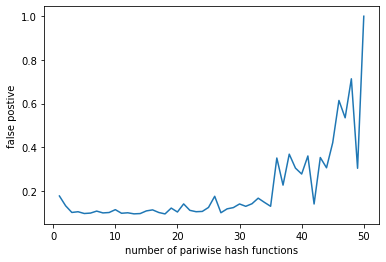

In [120]:
import matplotlib.pyplot as plt
plt.plot(k_list, fp_list)
plt.xlabel('number of pariwise hash functions')
plt.ylabel('false postive')
plt.show()

In [118]:
ex_list=[]
for f,k in zip(fp_list,k_list):
    ex=(1-np.exp(-k*g/n))**k
    ex_list.append(ex)

In [125]:
k_op=n/g*ln(2)
k_op

8.8722839111673

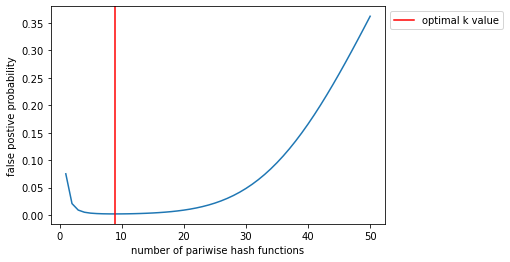

In [134]:
import matplotlib.pyplot as plt
plt.plot(k_list, ex_list)
plt.axvline(x=k_op, color='red', label = 'optimal k value')
plt.xlabel('number of pariwise hash functions')
plt.ylabel('false postive probability')
plt.legend(bbox_to_anchor = (1.0, 1), loc = 'upper left')
plt.show()

## Interpretation

After comparing two graphes, we can observe that the relation between number of hash functions and false positive match with the theoritical function. The optimal number of function follows the function 𝑘=𝑛/𝑚ln2, which is around nine. 